## TSP - Tabu Search

### Uzdevuma formulējums

Kurjeram nepieciešama palīdzība optimālākā maršruta sastādīšanā. Dots saraksts ar m piegādes punktiem, kas sastāv no x un y koordinātām, kā arī piegādājamā sūtījuma svara n. Zināms, ka kurjeram jāuzsāk maršruts no noliktavas, katrs piegādes punkts jāapmeklē vienu reizi un beigās jāatgriežas noliktavā. Papildus jācenšas piegādāt smagie sūtījumi pēc iespējas ātrāk.

### Algoritma apraksts

Uzdevuma risināšanai ir izvēlēts tabu search algoritms. Tabu search iteratīvi izpēta risinājumu telpu, pārvietojoties no viena potenciālā risinājuma uz citu. Tas izmanto tabu sarakstu, lai novērstu atgriešanos pie nesen apmeklētiem risinājumiem, tādējādi uzlabojot izpēti un novēršot algoritma iestāšanos lokālajos optimumos.

Implementētais algoritms sastāv no sekojošajiem soļiem:
1. Inicializācija - Tiek ģenerēti testa dati un patvaļīgi ģenerēts sākotnējais risinājums. Izmantojot random.seed() metodi tiek nodrošināts, ka radītie dati sakrītīs atkārtojot izpildi.
2. Iteratīvs cikls, kas darbojas līdz tiek izsmelta iespējamo risinājumu kopa, vai sasniegta max_interations inicializācijas parametra vērtība. 
3. Apkārtnes funkcija, kas balstās uz 2-opt swap algoritmu, lai ģenerētu kaimiņus.
4. Izmaksu funkcija uz katru kaimiņu, lai aprēķinātu maršruta izmaksu. Funkcija pielāgota lai ņemtu vērā arī nosacījumu pēc iespējas ātrāk piegādāt smagos sūtījumus. Tā seko šādai formulai: 
> Kopējās izmaksas = kopējais attālums + (alpha * (sūtījuma svars * piegādes secības indekss / 2))

Šajā gadījumā sūtījuma svara un piegādes secības indeksa reizinājums tiek dalīts ar 2, lai mazinātu svara ietekmi uz rezultātu. Papildus svara nozīmīgumu var ietekmēt izmantojot alpha parametru, kas ir viens no inicializācijas parametriem. Norādot alpha = 0 svars netiks ņemts vērā.

5. Tabu saraksta parvaldība, kas sevī ietver gājienu reģistrēšanu, kas rezultējušies jauna labākā maršruta atklāšanā. Tabu saraksta garumu iespējams kontrolēt pamainot tabu_size inicializācijas parametra vērtību.

Piegādes Punkti:
ID: 0, Koordinātas: (50, 50)
ID: 1, Koordinātas: (47.12, 46.54), Svars: 36 kg
ID: 2, Koordinātas: (50.35, 60.96), Svars: 14 kg
ID: 3, Koordinātas: (31.24, 12.19), Svars: 12 kg
ID: 4, Koordinātas: (45.72, 47.26), Svars: 12 kg
ID: 5, Koordinātas: (54.65, 73.27), Svars: 4 kg
ID: 6, Koordinātas: (20.59, 38.09), Svars: 90 kg
ID: 7, Koordinātas: (36.44, 46.07), Svars: 76 kg
ID: 8, Koordinātas: (42.89, 89.72), Svars: 98 kg
ID: 9, Koordinātas: (60.64, 20.93), Svars: 44 kg
ID: 10, Koordinātas: (47.57, 63.71), Svars: 98 kg


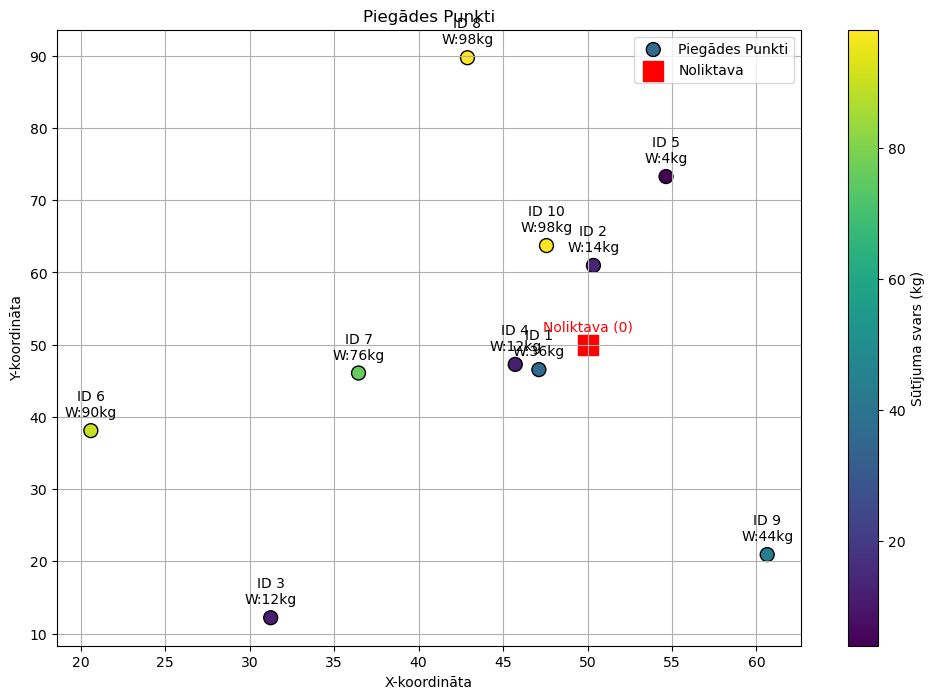


Uzsāk Tabu Search...

Iterācija: 1. Jauns zemāko izmaksu maršruts atrasts: 546.00
Iterācija: 2. Jauns zemāko izmaksu maršruts atrasts: 533.00
Iterācija: 3. Jauns zemāko izmaksu maršruts atrasts: 518.00
Iterācija: 4. Jauns zemāko izmaksu maršruts atrasts: 512.00
Iterācija: 5. Jauns zemāko izmaksu maršruts atrasts: 511.00
Iterācija: 6. Jauns zemāko izmaksu maršruts atrasts: 509.50
Iterācija: 13. Jauns zemāko izmaksu maršruts atrasts: 508.50
Iterācija: 14. Jauns zemāko izmaksu maršruts atrasts: 506.50
Izsmelta ne-tabu risinājumu kopa. Meklēšana tiek beigta.

Labākais Maršruts Atrasts:
0 -> 10 -> 8 -> 6 -> 7 -> 1 -> 9 -> 3 -> 4 -> 2 -> 5 -> 0
Kopējās Izmaksas: 506.50. Izpildes Laiks: 0.01s.


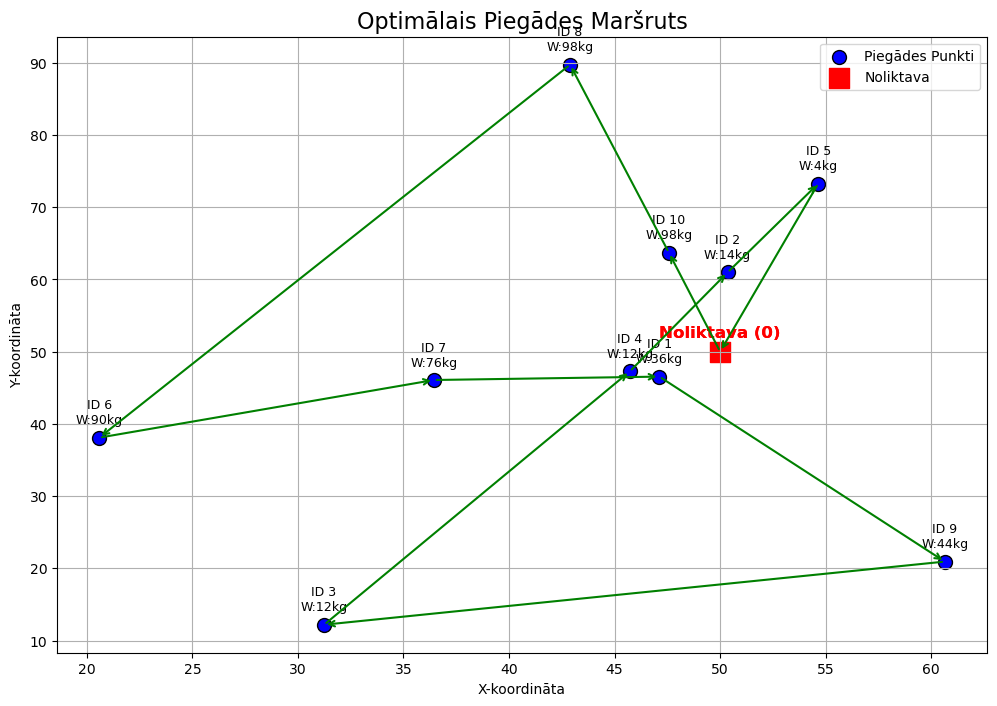

In [12]:
import random
import math
import time
import matplotlib.pyplot as plt

# Lokācijas klase
class Location:
    def __init__(self, id, x, y, weight=None):
        self.id = id          # Identifikators
        self.x = x            # X-koordināta
        self.y = y            # Y-koordināta
        self.weight = weight  # Sūtījuma svars

# Lieto pseido-eiklīda attāluma funkciju standarta funkcija vietā, 
# par cik TSPLIB testa datiem ir ATT tipa šķautņu svars (EDGE_WEIGHT_TYPE)
def pseudo_euclidean_distance(loc1, loc2):
    xd = loc1.x - loc2.x
    yd = loc1.y - loc2.y
    rij = math.sqrt((xd * xd + yd * yd) / 10.0)
    tij = round(rij)
    if tij < rij:
        dij = tij + 1
    else:
        dij = tij
    return dij

def calculate_total_distance(route):
    distance = 0.0
    for i in range(len(route) - 1):
        distance += pseudo_euclidean_distance(route[i], route[i + 1])
    return distance

# Funkcija, kas aprēķina svara "koeficentu"
def calculate_priority_penalty(route):
    penalty = 0.0
    # Ignorē pirmo un pēdējo punktu (noliktavu)
    for idx, loc in enumerate(route[1:-1], start=1):
        penalty += loc.weight * idx / 2
        
    return penalty

# Funkcija, kas aprēķina maršruta izmaksas
def calculate_cost(route, alpha):
    total_distance = calculate_total_distance(route)
    # Ignore pirmo un pēdējo lokāciju (noliktava)
    priority_penalty = calculate_priority_penalty(route)
    return total_distance + alpha * priority_penalty
    # return total_distance

# Patvaļīgi izvēlas sākotnējo maršrutu
def generate_initial_solution(locations, warehouse):
    delivery_locations = [loc for loc in locations if loc.id != warehouse.id]
    random.shuffle(delivery_locations)
    solution = [warehouse] + delivery_locations + [warehouse]
    return solution

# Funkcija maršruta pārģenerēšanai
def two_opt_swap(route, i, k):
    # route = ['A', 'B', 'C', 'D', 'E', 'F']
    # i = 2
    # k = 4
    # new_route = route[:i] + route[i:k+1][::-1] + route[k+1:]
    # new_route = ['A', 'B'] + ['E', 'D', 'C'] + ['F']
    new_route = route[:i] + route[i:k+1][::-1] + route[k+1:]
    return new_route

def generate_neighborhood(current_solution):
    neighborhood = []
    n = len(current_solution) - 2  # Piegādes punktu skaits
    # Ģenerē iespējamos kaimiņus
    for i in range(1, n):
        for k in range(i + 1, n + 1):
            neighbor = two_opt_swap(current_solution, i, k)
            move = (i, k)
            neighborhood.append((neighbor, move))
    return neighborhood

def tabu_search(locations, tabu_size, max_iterations, alpha):
    warehouse = locations[0]
    current_solution = generate_initial_solution(locations, warehouse)
    
    best_solution = current_solution.copy()
    best_cost = calculate_cost(best_solution, alpha)
    
    tabu_list = []
    
    # Iterē lai uzlabotu maršrutu kamēr sasniedz maksimālo iterāciju skaitu vai kad izsmelta ne-tabu risinājumu kopa
    for iteration in range(1, max_iterations + 1):
        neighborhood = generate_neighborhood(current_solution)
        # Izvērtē visus kaimiņus un izvēlas labāko, kas nav tabu sarakstā
        best_neighbor = None
        best_neighbor_cost = float('inf')
        best_move = None
        
        for neighbor, move in neighborhood:
            cost = calculate_cost(neighbor, alpha)
            if move not in tabu_list or cost < best_cost:
                if cost < best_neighbor_cost:
                    best_neighbor = neighbor
                    best_neighbor_cost = cost
                    best_move = move
        
        if best_neighbor is None:
            print("Izsmelta ne-tabu risinājumu kopa. Meklēšana tiek beigta.")
            break
        
        current_solution = best_neighbor
        current_cost = best_neighbor_cost
        
        tabu_list.append(best_move)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
        
        # Atjauno labāko risinājumu
        if current_cost < best_cost:
            best_solution = current_solution.copy()
            best_cost = current_cost
            print(f"Iterācija: {iteration}. Jauns zemāko izmaksu maršruts atrasts: {best_cost:.2f}")
    
    return best_solution, best_cost

def print_route(route):
    route_ids = [loc.id for loc in route]
    print(" -> ".join(map(str, route_ids)))

# Funkcija testa datu ģenerēšanai
def generate_test_data():
    # Nodefinē noliktavu
    warehouse = Location(id=0, x=50, y=50, weight=None)
    
    # Lokācijas parametri
    num_deliveries = 10  # Lokāciju skaits
    x_mean, x_std = 50, 20  # vidējā vērtība un standartnovirze priekš x-coordinātām
    y_mean, y_std = 50, 20  # vidējā vērtība un standartnovirze priekš y-coordinātām
    weight_min, weight_max = 1, 100  # Svars
    
    # Seed vērtība, lai atkārtoti ģenerējot tiktu ģenerēti tie paši dati
    random.seed(42)
    
    delivery_locations = []
    for i in range(1, num_deliveries + 1):
        # Uzģenerē piegādes punktu koordinātas
        x = random.gauss(x_mean, x_std)
        y = random.gauss(y_mean, y_std)
        
        weight = random.randint(weight_min, weight_max)
        
        loc = Location(id=i, x=round(x, 2), y=round(y, 2), weight=weight)
        delivery_locations.append(loc)
    
    locations = [warehouse] + delivery_locations
    
    return locations

# Maršruta vizualizācijas funkcija
def visualize_route(route, title="Piegādes Maršruts"):
    plt.figure(figsize=(12, 8))

    x = [loc.x for loc in route]
    y = [loc.y for loc in route]
    
    plt.scatter(x, y, c='blue', edgecolor='k', s=100, label='Piegādes Punkti')
    
    plt.scatter(route[0].x, route[0].y, c='red', marker='s', s=200, label='Noliktava')
    
    for loc in route:
        if loc.id == 0:
            plt.annotate(f'Noliktava ({loc.id})', (loc.x, loc.y), textcoords="offset points",
                         xytext=(0,10), ha='center', color='red', fontsize=12, fontweight='bold')
        else:
            plt.annotate(f'ID {loc.id}\nW:{loc.weight}kg', (loc.x, loc.y), textcoords="offset points",
                         xytext=(0,10), ha='center', fontsize=9)
    
    for i in range(len(route) - 1):
        start_loc = route[i]
        end_loc = route[i + 1]
        
        plt.annotate("",
                     xy=(end_loc.x, end_loc.y), xycoords='data',
                     xytext=(start_loc.x, start_loc.y), textcoords='data',
                     arrowprops=dict(arrowstyle="->", color='green', lw=1.5),
                     )
    
    plt.title(title, fontsize=16)
    plt.xlabel("X-koordināta")
    plt.ylabel("Y-koordināta")
    plt.legend()
    plt.grid(True)
    plt.show()

# Piegādes punktu vizualizācijas funkcija
def visualize_locations(locations, title="Piegādes Punkti"):
    warehouse = locations[0]
    deliveries = locations[1:]
    
    wx, wy = warehouse.x, warehouse.y
    dx = [loc.x for loc in deliveries]
    dy = [loc.y for loc in deliveries]
    weights = [loc.weight for loc in deliveries]
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(dx, dy, c=weights, cmap='viridis', marker='o', edgecolor='k', s=100, label='Piegādes Punkti')
    plt.scatter(wx, wy, c='red', marker='s', s=200, label='Noliktava')
    
    for loc in locations:
        if loc.id == 0:
            plt.annotate(f'Noliktava ({loc.id})', (loc.x, loc.y), textcoords="offset points", xytext=(0,10), ha='center', color='red')
        else:
            plt.annotate(f'ID {loc.id}\nW:{loc.weight}kg', (loc.x, loc.y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.title(title)
    plt.xlabel("X-koordināta")
    plt.ylabel("Y-koordināta")
    plt.legend()
    plt.grid(True)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Sūtījuma svars (kg)')
    plt.show()

def main():
    locations = generate_test_data()
    
    print("Piegādes Punkti:")
    for loc in locations:
        if loc.id == 0:
            print(f"ID: {loc.id}, Koordinātas: ({loc.x}, {loc.y})")
        else:
            print(f"ID: {loc.id}, Koordinātas: ({loc.x}, {loc.y}), Svars: {loc.weight} kg")
    
    visualize_locations(locations, title="Piegādes Punkti")
    
    print("\nUzsāk Tabu Search...\n")
    start_time = time.time()
    best_route, best_cost = tabu_search(locations, tabu_size=100, max_iterations=10000, alpha=0.5)
    end_time = time.time()
    print("\nLabākais Maršruts Atrasts:")
    print_route(best_route)
    print(f"Kopējās Izmaksas: {best_cost:.2f}. Izpildes Laiks: {end_time - start_time:.2f}s.")
    
    visualize_route(best_route, title="Optimālais Piegādes Maršruts")

if __name__ == "__main__":
    main()


### Testēšanas apraksts

Uz maziem piegādes punktu skaitiem testēšana un ar to saistītie aprēķini var tikt veikti manuāli, kas arī tika sākotnēji veikts, lai pārliecinātos par algoritma pareizu darbību. Programmas generate_test_data metode satur nepieciešamo kodu, lai izveidotu testa datus. Mainīgais num_deliveries nosaka cik piegādes punktu jāuzģenerē.

Lai papildus pārliecinātos par algoritma pareizu darbību, tika piemeklēta testēšanas kopa ar zināmu rezultātu. Datu kopas iegūšanai tika izvēlēts [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/), kas satur salīdzinoši daudz dažādu kvalitatīvu datu un rezultātu TSP tipa problēmām. Konkrēti šī uzdevuma testēšanas nolūkam tika izvēlētas att48.tsp un att532.tsp datu kopas, kas satur ASV pilsētu koordinātas. Datu kopas trūkums ir, ka tā nesatur papildus informāciju par svaru, kas pēc uzdevuma formulējuma ietekmē rezultātu prioritizējot punktus, kuros jāpiegādā sūtījumi ar lielāku svaru, bet svara ignorēšana fundamentāli neizmaina risinājuma pareizību, jo svars tiek ņemts vērā tikai izmaksu funkcijā, aprēķinot soda punktus, kuru apjomu ietekmē alpha inicializācijas parametrs.

TSPLIB testēšanas procesā tika izmantots alpha = 0, lai svars netiktu ņemts vērā un tabu_size = 100, max_iterations = 100000:

![Datu Kopa. Ja nedarbojas, skat. assets mapi - att48-data.png](/assets/att48-data.png)

Algoritma izpildes rezultātā tika iegūts: 
- Optimālais maršruts: 1 -> 9 -> 40 -> 15 -> 12 -> 11 -> 13 -> 25 -> 14 -> 23 -> 3 -> 22 -> 16 -> 41 -> 34 -> 29 -> 2 -> 26 -> 4 -> 35 -> 45 -> 10 -> 24 -> 42 -> 5 -> 48 -> 39 -> 32 -> 21 -> 47 -> 20 -> 33 -> 46 -> 36 -> 30 -> 43 -> 17 -> 27 -> 19 -> 37 -> 6 -> 28 -> 7 -> 18 -> 44 -> 31 -> 38 -> 8 -> 1
- Maršruta izmaksa: 10628.00, kas sakrīt ar TSPLIB sniegto atbildi un tika sasniegta 5882 iterācijās
- Izpildes laiks: 213.21s

![Rezultāts. Ja nedarbojas, skat. assets mapi - att48-result.png](/assets/att48-result.png)

Papildus tika mēģināts veikt arī testēšanu uz att532.tsp datu kopu, taču tās piegādes punktu skaita dēļ, nepieciešamo iterāciju apjoms un izpildes laiks bija pārāk liels, lai iegūtu rezultātu. (Algoritms tika darbināts tuvu pie 60 minūtēm)

Piegādes Punkti:
ID: 1, Koordinātas: (6734.0, 1453.0), Svars: 0 kg
ID: 2, Koordinātas: (2233.0, 10.0), Svars: 0 kg
ID: 3, Koordinātas: (5530.0, 1424.0), Svars: 0 kg
ID: 4, Koordinātas: (401.0, 841.0), Svars: 0 kg
ID: 5, Koordinātas: (3082.0, 1644.0), Svars: 0 kg
ID: 6, Koordinātas: (7608.0, 4458.0), Svars: 0 kg
ID: 7, Koordinātas: (7573.0, 3716.0), Svars: 0 kg
ID: 8, Koordinātas: (7265.0, 1268.0), Svars: 0 kg
ID: 9, Koordinātas: (6898.0, 1885.0), Svars: 0 kg
ID: 10, Koordinātas: (1112.0, 2049.0), Svars: 0 kg
ID: 11, Koordinātas: (5468.0, 2606.0), Svars: 0 kg
ID: 12, Koordinātas: (5989.0, 2873.0), Svars: 0 kg
ID: 13, Koordinātas: (4706.0, 2674.0), Svars: 0 kg
ID: 14, Koordinātas: (4612.0, 2035.0), Svars: 0 kg
ID: 15, Koordinātas: (6347.0, 2683.0), Svars: 0 kg
ID: 16, Koordinātas: (6107.0, 669.0), Svars: 0 kg
ID: 17, Koordinātas: (7611.0, 5184.0), Svars: 0 kg
ID: 18, Koordinātas: (7462.0, 3590.0), Svars: 0 kg
ID: 19, Koordinātas: (7732.0, 4723.0), Svars: 0 kg
ID: 20, Koordinātas: (5900.0

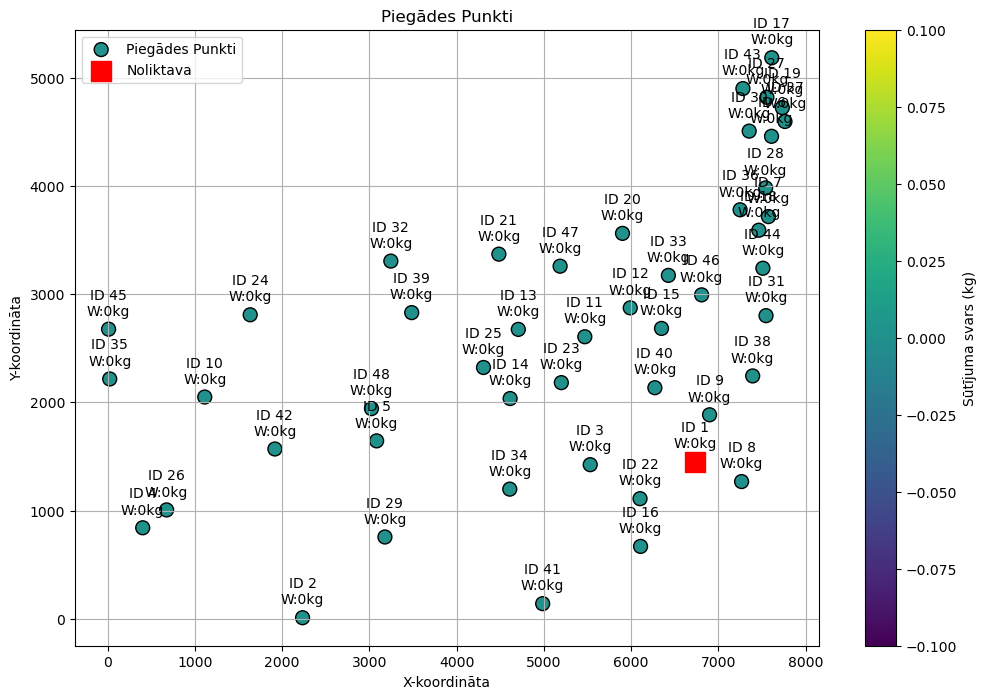


Uzsāk Tabu Search...

Iterācija: 1. Jauns zemāko izmaksu maršruts atrasts: 43572.00
Iterācija: 2. Jauns zemāko izmaksu maršruts atrasts: 40417.00
Iterācija: 3. Jauns zemāko izmaksu maršruts atrasts: 37350.00
Iterācija: 4. Jauns zemāko izmaksu maršruts atrasts: 34831.00
Iterācija: 5. Jauns zemāko izmaksu maršruts atrasts: 32550.00
Iterācija: 6. Jauns zemāko izmaksu maršruts atrasts: 30548.00
Iterācija: 7. Jauns zemāko izmaksu maršruts atrasts: 29212.00
Iterācija: 8. Jauns zemāko izmaksu maršruts atrasts: 27849.00
Iterācija: 9. Jauns zemāko izmaksu maršruts atrasts: 26601.00
Iterācija: 10. Jauns zemāko izmaksu maršruts atrasts: 25388.00
Iterācija: 11. Jauns zemāko izmaksu maršruts atrasts: 24324.00
Iterācija: 12. Jauns zemāko izmaksu maršruts atrasts: 23095.00
Iterācija: 13. Jauns zemāko izmaksu maršruts atrasts: 22029.00
Iterācija: 14. Jauns zemāko izmaksu maršruts atrasts: 21099.00
Iterācija: 15. Jauns zemāko izmaksu maršruts atrasts: 20265.00
Iterācija: 16. Jauns zemāko izmaksu maršr

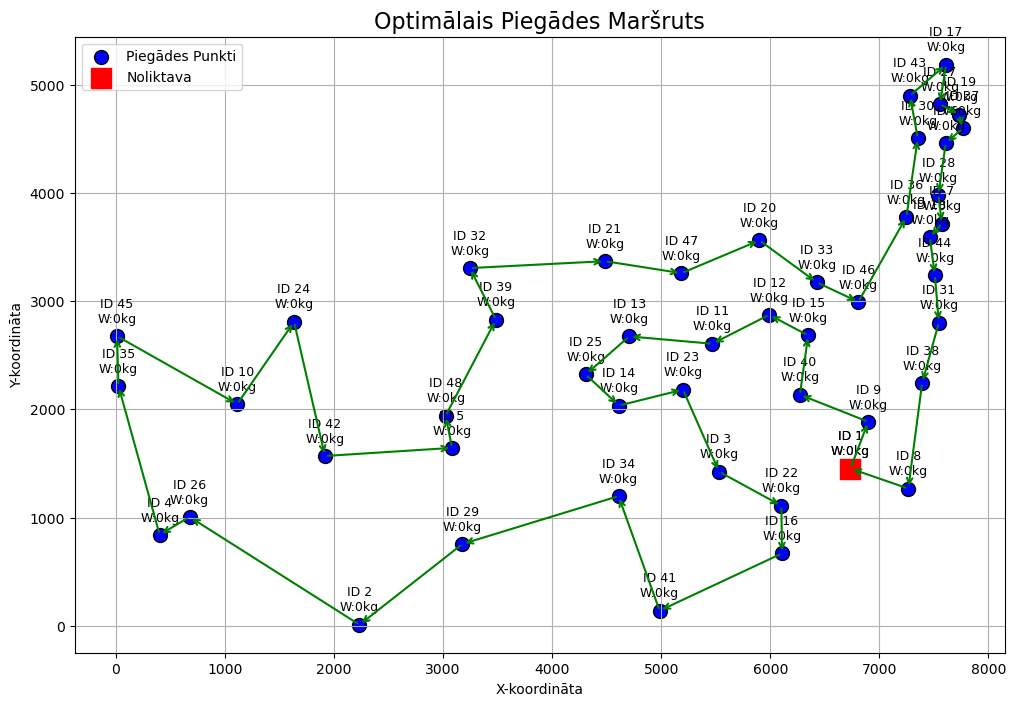

In [13]:
# Pārrakstīta testa datu izveides funkcija, kas ielādē datus no tsplib faila
def generate_test_data():
    locations = []
    with open("data/att48.tsp", 'r') as f:
        lines = f.readlines()

    node_coord_section_found = False
    for line in lines:
        line = line.strip()
        if line == 'NODE_COORD_SECTION':
            node_coord_section_found = True
            continue
        if line == 'EOF':
            break
        if node_coord_section_found:
            parts = line.split()
            if len(parts) >= 3:
                node_id = int(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                loc = Location(id=node_id, x=x, y=y, weight=0)
                locations.append(loc)
    return locations

def main():
    locations = generate_test_data()

    visualize_locations(locations, title="Piegādes Punkti")
    
    print("\nUzsāk Tabu Search...\n")
    start_time = time.time()
    best_route, best_cost = tabu_search(locations, tabu_size=100, max_iterations=10000, alpha=0)
    end_time = time.time()
    print("\nLabākais Maršruts Atrasts:")
    print_route(best_route)
    print(f"Kopējās Izmaksas: {best_cost:.2f}. Izpildes Laiks: {end_time - start_time:.2f}s.")
    
    visualize_route(best_route, title="Optimālais Piegādes Maršruts")
    
if __name__ == "__main__":
    main()

In [ ]:
# Pārrakstīta testa datu izveides funkcija, kas ielādē datus no tsplib faila
def generate_test_data():
    locations = []
    with open("data/att532.tsp", 'r') as f:
        lines = f.readlines()

    node_coord_section_found = False
    for line in lines:
        line = line.strip()
        if line == 'NODE_COORD_SECTION':
            node_coord_section_found = True
            continue
        if line == 'EOF':
            break
        if node_coord_section_found:
            parts = line.split()
            if len(parts) >= 3:
                node_id = int(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                loc = Location(id=node_id, x=x, y=y, weight=0)
                locations.append(loc)
    return locations

def main():
    locations = generate_test_data()
    
    visualize_locations(locations, title="Piegādes Punkti")
    
    print("\nUzsāk Tabu Search...\n")
    start_time = time.time()
    best_route, best_cost = tabu_search(locations, tabu_size=100, max_iterations=10000, alpha=0)
    end_time = time.time()
    print("\nLabākais Maršruts Atrasts:")
    print_route(best_route)
    print(f"Kopējās Izmaksas: {best_cost:.2f}. Izpildes Laiks: {end_time - start_time:.2f}s.")
    
    visualize_route(best_route, title="Optimālais Piegādes Maršruts")
    
if __name__ == "__main__":
    main()